## *PROJEKT BBC NEWS CLASIFICATION*
Julia Żółtowska

Dataset: BBC articles fulltext and category. Zbiór zawiera 2225 artykułów ze strony BBC news
website w formie dokumnetów tekstowych, podzielonych na 5 grup: business, tech, sport,
entertaiment, politics. Atrybuty tesktowe: Kategoria, TekstArtykułuTytuł

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Preprocessing text
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [105]:
#Wczytanie danych
articles = pd.read_csv('/content/drive/MyDrive/Projekt_WUM/dane/bbc-text.csv')
articles.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


#Eksploracyjna Analiza Danych (EDA)

In [106]:
#Wyświetlenie szczegółowych informacji o kolumnach
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [107]:
#Wyświetlenie kategorii artykułów w datasetcie articles
articles['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [108]:
#Grupuję dane na podstawie kategorii
articles.groupby('category').count()

,text
category,
business,510
entertainment,386
politics,417
sport,511
tech,401


In [109]:
#Przegladam dataset na podstawie długości tekstu atrykułu i wyświetlam 10 pierwszych wierszy
articles['length'] = articles['text'].apply(len)
articles.head(10)

,category,text,length
0,tech,tv future in the hands of viewers with home th...,4333
1,business,worldcom boss left books alone former worldc...,1842
2,sport,tigers wary of farrell gamble leicester say ...,1342
3,sport,yeading face newcastle in fa cup premiership s...,2176
4,entertainment,ocean s twelve raids box office ocean s twelve...,1579
5,politics,howard hits back at mongrel jibe michael howar...,3533
6,politics,blair prepares to name poll date tony blair is...,1486
7,sport,henman hopes ended in dubai third seed tim hen...,1051
8,sport,wilkinson fit to face edinburgh england captai...,983
9,entertainment,last star wars not for children the sixth an...,1248


<Axes: ylabel='Frequency'>

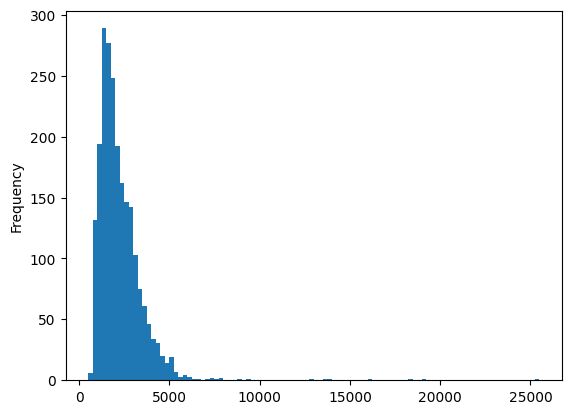

In [110]:
#histogram przedstawiający rozkład wartości w kolumnie 'length'
articles['length'].plot(bins=100,kind='hist')

In [111]:
# Wyświetlam  długość najdłuższego artykułu w datasetcie
articles['length'].max()

25483

In [112]:
#wyświetlam wartość kolumny "category" dla wierszy, w których długość artykułu jest nawiększa
print(articles[articles['length'] == articles['length'].max()]['category'])

408    politics
Name: category, dtype: object


array([[<Axes: title={'center': 'business'}>,
        <Axes: title={'center': 'entertainment'}>],
       [<Axes: title={'center': 'politics'}>,
        <Axes: title={'center': 'sport'}>],
       [<Axes: title={'center': 'tech'}>, <Axes: >]], dtype=object)

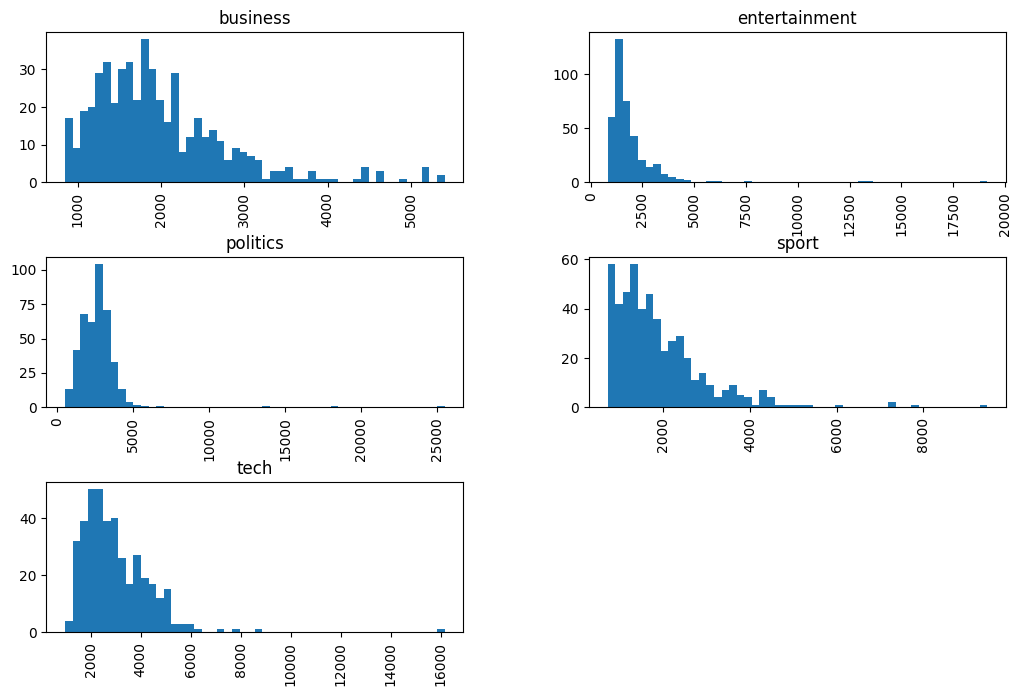

In [113]:
#Generuję histogramy, które pokazują rozkład wartości dotyczący długości artykułów w każdej kategorii
articles.hist(column='length', by='category', bins=50, figsize=(12,8))

# Przetwarzanie danych

Przygotowanie funkcji, która będzie wykorzystywana do przygotowania tekstu artykołów do klasyfikacji

In [114]:
def text_processing(text):

    #TOKENIZACJA
    # Wykonałam tokenizację tekstu artykułów, używając biblioteki NLTK, czyli Natural Language Toolkit
    #Wykorzystałam funkcję word_tokenize, która dokonuje tokenizacji tekstu artykułów na poziomie słów.
    tokens = nltk.word_tokenize(text)
    #jako wynik otrzymałam liste tokenów, czyli słów

    #USUWANIE STOP WORDS
    # Następnie utworzyłam zbiór słów tzw. stop words dla języka angielskiego, które
    #dostracza biblioteka NLTK, w związku z tym, że artykuły po angielsku
    #to używam słów stop words z języka angielskiego.
    stop_words = set(stopwords.words("english"))


    #Przeszłam po liście tokenów i sprawdzałam czy ten token nie znajduję się
    #w zbiorze stop words, jeśli token nie jest tym, ze zbioru stop words
    #to zostaje zachowany no i dodany do nowej listy tokens
    tokens = [word for word in tokens if word not in stop_words]

    # USUWAM CYFRY, ZNAKI INTERPUNKCYJNE I SPECJALNE
    regex = '[a-z]+' #używam  wzorca tak zwanego wyrażenia regularnego używanego do
    #dopasowywania ciągów znaków, które składając się tylko z małych liter, czyli że token
    #musi zawierać jedną albo więcej małych liter

    #Przechodzę przez każdy token w liście tokens i sprawdzam, czy pasuje on do
    #wzorca wyrażenia regex. Poprzez re.match(regex, word) sprawdzałam
    #czy token pasuje do wzorca, jeśli pasuje to zostaje dodany do tokens
    tokens = [word for word in tokens if re.match(regex, word)]
    #Rezultat to, że zachowane są tylko te tokeny, które składają się tylko z małych liter.

    # Lematyzacja: konwertowanie słów do ich podstawowej formy
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    #Stworzyłam obiekt lematyzatora z biblioteki NLTK
    tokens = [lem.lemmatize(word, pos='v') for word in tokens]
    #przechodzę przez każdy token i go lemantyzuję za pomocą metody lemmatize obiektu lem. Parametr pod='v', czyli
    #słowo podczas lemnatyzacji traktowane jako ver,b czyli czasownik
    return tokens

In [115]:
# Przekształcenie etykiet z postaci tekstowej na numeryczną
 #użyłam Label Encodera, bo on analizuje unikalne wartości w kolumnie
#,,category"  no i tworzy mapowanie między tymi wartościami a liczbami całkowitymi np. artykuł z kategorii Sport może mieć po zastosowaniu kodowania etykietę 1
label_encoder = LabelEncoder()
articles['category_enc'] = label_encoder.fit_transform(articles['category'])
#w wyniku otrzymałam nową kolumnę, która ma zakodowane wartości kategorii artykółów

In [116]:
#Sprawdzam jak wyglądają zakodowane klasy z kolumny category
articles['category_enc']

0       4
1       0
2       3
3       3
4       1
       ..
2220    0
2221    2
2222    1
2223    2
2224    3
Name: category_enc, Length: 2225, dtype: int64

# Podział danych

In [117]:
## Dzielę dane na treningowe i testowe (stosunek 80:20)
x_train, x_test, y_train, y_test = train_test_split(articles['text'], articles['category_enc'], test_size=0.2, random_state=42)

In [118]:
# Dzielę dane treningowe na treningowe i walidacyjne (stosunek 80:20)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

Bag of words - Tworzenie reprezentacji bag of words

In [119]:
# Najpierw wykorzystałam obiekt CountVectorizer, który przekszatłaca dane wejściowe na reprezentację numeryczną,
#w którym każdy artykuł jest kodowany jako wektor, który zawiera konkretną liczbę wystąpień słów w tym artykule.
#Dodatkowo do tego obiektu CountVectorizer przekazywana jest funkcja, którą wcześniej zdefiniowałam czyszcząca tekst atrykułów.
bow_transformer = CountVectorizer(analyzer= text_processing).fit(x_train)

#Następnie wykonałam przekształecenie bag of words na danych treningowych,walidacyjnych i testowych.
x_train_bow = bow_transformer.transform(x_train)
x_val_bow = bow_transformer.transform(x_val)
x_test_bow = bow_transformer.transform(x_test)

TF-IDF (Term Frequency-Inverse Document Frequency) - Konwersja reprezentacji bag of words na reprezentację TF-IDF

In [120]:
#Tworzę obiekt TfidfTransformer z biblioteki scikit-learn, służący do obliczania wag TF-IDF dla
#przekształconych reprezentacji Bag of Words a poprzez fit dostosowuje model do danych treningowych
#i obliczam statystki, które są potrzebne do obliczenia wag TF-IDF.
tfidf_transformer = TfidfTransformer().fit(x_train_bow)


#Następnie wykouje przekształcenie reprezentacji Bag of Words danych treningowych, walidacyjnych i testowych na reprezentację TD-IDF
#, w której wartości wektorów zostają przeskalowane na podstawie wag TF-IDF, wykorzystując stworzony obiekt tfidf_transformer

x_train_tfidf = tfidf_transformer.transform(x_train_bow)
x_val_tfidf = tfidf_transformer.transform(x_val_bow)
x_test_tfidf = tfidf_transformer.transform(x_test_bow)


Konwersja rzadkich macierzy na gęste tablice numpy

 Przez to, że wcześniej zrobiłam przekształcenie TF-IDF na reprezentacjach Bag of Words dla danych treningowych, walidacyjnych i testowych w wyniku otrzymałam rzadkie macierze, które to przechowują dane w postaci skompresowanej. (przeczytałałam, że robi się tak, żeby efektywniej zarządzać pamięcią)

Celem tej konwersji było to, żeby x_train_ready,  x_val_ready i x_test_ready przechowywały przekształcone reprezentacje TF-IDF jako gęste tablice numpy, co umożliwiło mi wykorzystanie ich w uczeniu modelu.

In [121]:
x_train_ready = x_train_tfidf.toarray()
x_val_ready = x_val_tfidf.toarray()
x_test_ready = x_test_tfidf.toarray()


Konwersja danych  do formatu one-hot encoded ( wykorzystuję one-hot encoding)

In [122]:
num_classes = len(label_encoder.classes_) #obliczyłam liczbę klas poprzez zliczenie tych unikalnych w obiekcie label_encoder.classes i wartość z zostaje
#przypisane do num_classes

#wykonałam przekształcenie etykiet treningowych, walidacyjnych i testowych na postać one-hot encoding
#Użyłam funkcji "to_categorical", która przekształaca etykiety klas na postać binarnego kodu 1 of n, w którym każda klasa jest reprezetowana przez
# wektor zer oraz jedynek o długości num_classes
y_train_ready = to_categorical(y_train, num_classes)
y_val_ready= to_categorical(y_val, num_classes)
y_test_ready = to_categorical(y_test, num_classes)



# Wytrenowanie modelu referencyjnego - BASELINE
Definiuję, kompiluję oraz trenuję model jednokierunkowej, wielowarstwowej sieci neuronowej o pierwszej warstwie gęstej (Dense), zawierającą 16 neuronów i z funkcją aktywacji RELU. Drugą warstwą gęstą, która też ma 16 neuronów o funkcji aktywacji RELU. Trzecią warstwą gęstą (Dense) o rozmiarze num_classes, czyli liczbie klas (5) oraz funkcją aktywacji softmax.

In [123]:
from tensorflow.keras.models import Sequential


model = Sequential([
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
                    epochs=30, batch_size=200,
                    validation_data=(x_val_ready, y_val_ready))

Epoch 1/30
8/8 [==============================] - 1s 70ms/step - loss: 1.5970 - accuracy: 0.2451 - val_loss: 1.5683 - val_accuracy: 0.3511
Epoch 2/30
8/8 [==============================] - 0s 48ms/step - loss: 1.5419 - accuracy: 0.4080 - val_loss: 1.5131 - val_accuracy: 0.4129
Epoch 3/30
8/8 [==============================] - 0s 39ms/step - loss: 1.4739 - accuracy: 0.4565 - val_loss: 1.4514 - val_accuracy: 0.4213
Epoch 4/30
8/8 [==============================] - 0s 40ms/step - loss: 1.4005 - accuracy: 0.5014 - val_loss: 1.3842 - val_accuracy: 0.4635
Epoch 5/30
8/8 [==============================] - 0s 44ms/step - loss: 1.3173 - accuracy: 0.5569 - val_loss: 1.3153 - val_accuracy: 0.4860
Epoch 6/30
8/8 [==============================] - 0s 41ms/step - loss: 1.2337 - accuracy: 0.5962 - val_loss: 1.2444 - val_accuracy: 0.5197
Epoch 7/30
8/8 [==============================] - 0s 39ms/step - loss: 1.1481 - accuracy: 0.6187 - val_loss: 1.1728 - val_accuracy: 0.5365
Epoch 8/30
8/8 [===========

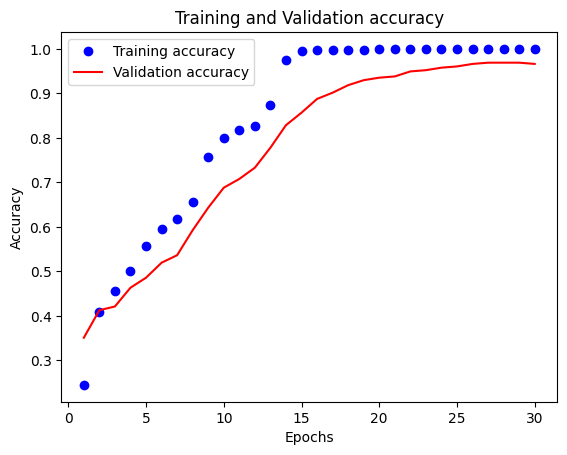

In [124]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

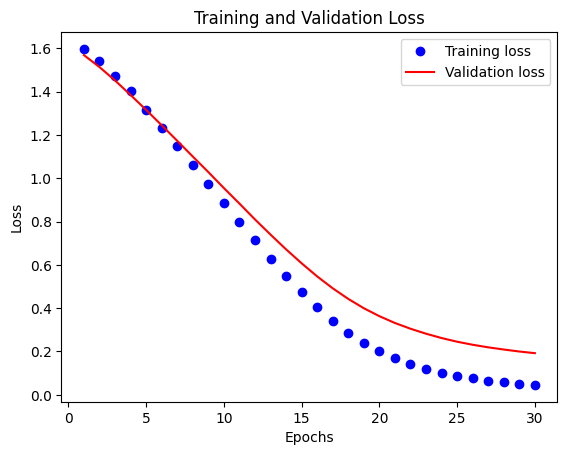

In [125]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [127]:
from tensorflow.keras.models import Sequential


model = Sequential([
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
                    epochs=30, batch_size=200,
                    validation_data=(x_test_ready, y_test_ready))

Epoch 1/30
8/8 [==============================] - 2s 70ms/step - loss: 1.6027 - accuracy: 0.4185 - val_loss: 1.5856 - val_accuracy: 0.5596
Epoch 2/30
8/8 [==============================] - 0s 40ms/step - loss: 1.5650 - accuracy: 0.6685 - val_loss: 1.5459 - val_accuracy: 0.6427
Epoch 3/30
8/8 [==============================] - 0s 40ms/step - loss: 1.5126 - accuracy: 0.7500 - val_loss: 1.4975 - val_accuracy: 0.7124
Epoch 4/30
8/8 [==============================] - 0s 47ms/step - loss: 1.4479 - accuracy: 0.8378 - val_loss: 1.4405 - val_accuracy: 0.7551
Epoch 5/30
8/8 [==============================] - 0s 46ms/step - loss: 1.3730 - accuracy: 0.8848 - val_loss: 1.3757 - val_accuracy: 0.7798
Epoch 6/30
8/8 [==============================] - 0s 42ms/step - loss: 1.2880 - accuracy: 0.9263 - val_loss: 1.3031 - val_accuracy: 0.8202
Epoch 7/30
8/8 [==============================] - 0s 43ms/step - loss: 1.1935 - accuracy: 0.9473 - val_loss: 1.2233 - val_accuracy: 0.8494
Epoch 8/30
8/8 [===========

In [131]:
from sklearn.metrics import classification_report
import numpy as np

# Generuję predykcję na testowym i przekształcam przewidywania
#z zakodowanego formatu one-hot na etykiety
y_predition = model.predict(x_test_ready)
y_pred_labels = np.argmax(y_predition, axis=1)

# Generuję classification raport
report = classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_)
print(report)

14/14 [==============================] - 0s 2ms/step
               precision    recall  f1-score   support

     business       0.96      0.95      0.96       101
entertainment       1.00      0.95      0.97        81
     politics       0.94      0.98      0.96        83
        sport       0.99      1.00      0.99        98
         tech       0.98      0.99      0.98        82

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



## Dokonuję wyboru reugularyzacji
Porównałam drop out (dropout rate 0.2, 0.5) oraz L2 (0.002, 0.001 )

*!!!! Podczas  wszystkich eksperymentów jeśli wynik val_accuracy był wyższy niż w modelu biasowym także sprawdzałam wyniki tego modelu na danych testowych, lecz nie zmieniałam nazwy validation data tylko zmieniałałam dane na testowe np.validation_data=(x_test_ready, y_test_ready)!!!!!*

DROP OUT
*dropout rate = 0.2*

In [133]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
model = Sequential([
  Dense(16, activation='relu'),
  Dropout(0.2),
  Dense(16, activation='relu'),
  Dropout(0.2),
  Dense(num_classes, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
epochs=30, batch_size=128,
validation_data=(x_val_ready, y_val_ready))

Epoch 1/30
12/12 [==============================] - 3s 99ms/step - loss: 1.5966 - accuracy: 0.3673 - val_loss: 1.5675 - val_accuracy: 0.5056
Epoch 2/30
12/12 [==============================] - 0s 21ms/step - loss: 1.5365 - accuracy: 0.5091 - val_loss: 1.4986 - val_accuracy: 0.5281
Epoch 3/30
12/12 [==============================] - 0s 21ms/step - loss: 1.4507 - accuracy: 0.5506 - val_loss: 1.4124 - val_accuracy: 0.6152
Epoch 4/30
12/12 [==============================] - 0s 22ms/step - loss: 1.3533 - accuracy: 0.6187 - val_loss: 1.3113 - val_accuracy: 0.6826
Epoch 5/30
12/12 [==============================] - 0s 21ms/step - loss: 1.2324 - accuracy: 0.6784 - val_loss: 1.1981 - val_accuracy: 0.6994
Epoch 6/30
12/12 [==============================] - 0s 21ms/step - loss: 1.1098 - accuracy: 0.7205 - val_loss: 1.0789 - val_accuracy: 0.7388
Epoch 7/30
12/12 [==============================] - 0s 21ms/step - loss: 0.9978 - accuracy: 0.7458 - val_loss: 0.9639 - val_accuracy: 0.7612
Epoch 8/30
12

In [134]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
model = Sequential([
  Dense(16, activation='relu'),
  Dropout(0.2),
  Dense(16, activation='relu'),
  Dropout(0.2),
  Dense(num_classes, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
epochs=30, batch_size=128,
validation_data=(x_test_ready, y_test_ready))

Epoch 1/30
12/12 [==============================] - 2s 81ms/step - loss: 1.6030 - accuracy: 0.3996 - val_loss: 1.5871 - val_accuracy: 0.8022
Epoch 2/30
12/12 [==============================] - 1s 53ms/step - loss: 1.5677 - accuracy: 0.6749 - val_loss: 1.5393 - val_accuracy: 0.9056
Epoch 3/30
12/12 [==============================] - 0s 38ms/step - loss: 1.5050 - accuracy: 0.7669 - val_loss: 1.4729 - val_accuracy: 0.9326
Epoch 4/30
12/12 [==============================] - 0s 27ms/step - loss: 1.4307 - accuracy: 0.7704 - val_loss: 1.3908 - val_accuracy: 0.9438
Epoch 5/30
12/12 [==============================] - 0s 25ms/step - loss: 1.3338 - accuracy: 0.8020 - val_loss: 1.2923 - val_accuracy: 0.9461
Epoch 6/30
12/12 [==============================] - 0s 26ms/step - loss: 1.2180 - accuracy: 0.8532 - val_loss: 1.1792 - val_accuracy: 0.9461
Epoch 7/30
12/12 [==============================] - 0s 30ms/step - loss: 1.0909 - accuracy: 0.8694 - val_loss: 1.0541 - val_accuracy: 0.9506
Epoch 8/30
12

Wyniki: val_accuracy 0.9691, lepsza niż w modelu biasowym

Zastosowanie regularyzacji - DROP OUT 0.5

In [136]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
model = Sequential([
Dense(16, activation='relu'),
Dropout(0.5),
Dense(16, activation='relu'),
Dropout(0.5),
Dense(num_classes, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
epochs=30, batch_size=128,
validation_data=(x_val_ready, y_val_ready))

Epoch 1/30
12/12 [==============================] - 2s 85ms/step - loss: 1.6021 - accuracy: 0.3076 - val_loss: 1.5818 - val_accuracy: 0.5225
Epoch 2/30
12/12 [==============================] - 1s 47ms/step - loss: 1.5639 - accuracy: 0.3961 - val_loss: 1.5285 - val_accuracy: 0.5478
Epoch 3/30
12/12 [==============================] - 1s 47ms/step - loss: 1.5094 - accuracy: 0.4579 - val_loss: 1.4628 - val_accuracy: 0.6489
Epoch 4/30
12/12 [==============================] - 1s 69ms/step - loss: 1.4427 - accuracy: 0.4712 - val_loss: 1.3893 - val_accuracy: 0.6601
Epoch 5/30
12/12 [==============================] - 1s 65ms/step - loss: 1.3766 - accuracy: 0.5183 - val_loss: 1.3079 - val_accuracy: 0.7528
Epoch 6/30
12/12 [==============================] - 1s 70ms/step - loss: 1.2992 - accuracy: 0.5358 - val_loss: 1.2202 - val_accuracy: 0.8146
Epoch 7/30
12/12 [==============================] - 1s 66ms/step - loss: 1.2417 - accuracy: 0.5309 - val_loss: 1.1360 - val_accuracy: 0.8455
Epoch 8/30
12

In [137]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
model = Sequential([
Dense(16, activation='relu'),
Dropout(0.5),
Dense(16, activation='relu'),
Dropout(0.5),
Dense(num_classes, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
epochs=30, batch_size=128,
validation_data=(x_test_ready, y_test_ready))

Epoch 1/30
12/12 [==============================] - 2s 56ms/step - loss: 1.5996 - accuracy: 0.2823 - val_loss: 1.5761 - val_accuracy: 0.5640
Epoch 2/30
12/12 [==============================] - 0s 34ms/step - loss: 1.5528 - accuracy: 0.4206 - val_loss: 1.5228 - val_accuracy: 0.6247
Epoch 3/30
12/12 [==============================] - 0s 31ms/step - loss: 1.4985 - accuracy: 0.4340 - val_loss: 1.4611 - val_accuracy: 0.6539
Epoch 4/30
12/12 [==============================] - 0s 38ms/step - loss: 1.4364 - accuracy: 0.4712 - val_loss: 1.3942 - val_accuracy: 0.6966
Epoch 5/30
12/12 [==============================] - 1s 46ms/step - loss: 1.3811 - accuracy: 0.5007 - val_loss: 1.3248 - val_accuracy: 0.7393
Epoch 6/30
12/12 [==============================] - 0s 33ms/step - loss: 1.3242 - accuracy: 0.4972 - val_loss: 1.2547 - val_accuracy: 0.7798
Epoch 7/30
12/12 [==============================] - 0s 38ms/step - loss: 1.2506 - accuracy: 0.5463 - val_loss: 1.1823 - val_accuracy: 0.8315
Epoch 8/30
12

Regularyzacja L2 - Parametr 0.002

In [139]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers


model = Sequential([
    Dense(16, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(16, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
                    epochs=30, batch_size=200,
                    validation_data=(x_val_ready, y_val_ready))

Epoch 1/30
8/8 [==============================] - 3s 112ms/step - loss: 1.6756 - accuracy: 0.4284 - val_loss: 1.6307 - val_accuracy: 0.5843
Epoch 2/30
8/8 [==============================] - 1s 64ms/step - loss: 1.6059 - accuracy: 0.7247 - val_loss: 1.5826 - val_accuracy: 0.6770
Epoch 3/30
8/8 [==============================] - 0s 60ms/step - loss: 1.5560 - accuracy: 0.7739 - val_loss: 1.5431 - val_accuracy: 0.7135
Epoch 4/30
8/8 [==============================] - 0s 60ms/step - loss: 1.5089 - accuracy: 0.8230 - val_loss: 1.5029 - val_accuracy: 0.7303
Epoch 5/30
8/8 [==============================] - 0s 40ms/step - loss: 1.4585 - accuracy: 0.8441 - val_loss: 1.4587 - val_accuracy: 0.7921
Epoch 6/30
8/8 [==============================] - 0s 30ms/step - loss: 1.4047 - accuracy: 0.8729 - val_loss: 1.4116 - val_accuracy: 0.8146
Epoch 7/30
8/8 [==============================] - 0s 28ms/step - loss: 1.3481 - accuracy: 0.9066 - val_loss: 1.3622 - val_accuracy: 0.8483
Epoch 8/30
8/8 [==========

In [140]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers


model = Sequential([
    Dense(16, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(16, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
                    epochs=30, batch_size=200,
                    validation_data=(x_test_ready, y_test_ready))

Epoch 1/30
8/8 [==============================] - 2s 120ms/step - loss: 1.6748 - accuracy: 0.4242 - val_loss: 1.6266 - val_accuracy: 0.6652
Epoch 2/30
8/8 [==============================] - 0s 32ms/step - loss: 1.5963 - accuracy: 0.7956 - val_loss: 1.5690 - val_accuracy: 0.7640
Epoch 3/30
8/8 [==============================] - 0s 36ms/step - loss: 1.5334 - accuracy: 0.8982 - val_loss: 1.5193 - val_accuracy: 0.8337
Epoch 4/30
8/8 [==============================] - 0s 33ms/step - loss: 1.4731 - accuracy: 0.9452 - val_loss: 1.4679 - val_accuracy: 0.8607
Epoch 5/30
8/8 [==============================] - 0s 36ms/step - loss: 1.4100 - accuracy: 0.9600 - val_loss: 1.4137 - val_accuracy: 0.8787
Epoch 6/30
8/8 [==============================] - 0s 37ms/step - loss: 1.3429 - accuracy: 0.9677 - val_loss: 1.3555 - val_accuracy: 0.8989
Epoch 7/30
8/8 [==============================] - 0s 35ms/step - loss: 1.2724 - accuracy: 0.9740 - val_loss: 1.2941 - val_accuracy: 0.9169
Epoch 8/30
8/8 [==========

Regularyzacja L2 - parametr 0.001

In [142]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers


model = Sequential([
    Dense(16, kernel_regularizer=regularizers.l2(0.001), activation="relu"),
    Dense(16, kernel_regularizer=regularizers.l2(0.001), activation="relu"),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
                    epochs=30, batch_size=128,
                    validation_data=(x_val_ready, y_val_ready))

Epoch 1/30
12/12 [==============================] - 3s 76ms/step - loss: 1.6297 - accuracy: 0.4108 - val_loss: 1.5882 - val_accuracy: 0.5478
Epoch 2/30
12/12 [==============================] - 1s 46ms/step - loss: 1.5548 - accuracy: 0.6454 - val_loss: 1.5201 - val_accuracy: 0.6124
Epoch 3/30
12/12 [==============================] - 1s 42ms/step - loss: 1.4735 - accuracy: 0.7535 - val_loss: 1.4452 - val_accuracy: 0.7163
Epoch 4/30
12/12 [==============================] - 0s 36ms/step - loss: 1.3831 - accuracy: 0.8034 - val_loss: 1.3625 - val_accuracy: 0.7472
Epoch 5/30
12/12 [==============================] - 0s 31ms/step - loss: 1.2833 - accuracy: 0.8736 - val_loss: 1.2719 - val_accuracy: 0.8090
Epoch 6/30
12/12 [==============================] - 0s 29ms/step - loss: 1.1765 - accuracy: 0.9122 - val_loss: 1.1776 - val_accuracy: 0.8567
Epoch 7/30
12/12 [==============================] - 0s 29ms/step - loss: 1.0674 - accuracy: 0.9473 - val_loss: 1.0840 - val_accuracy: 0.8820
Epoch 8/30
12

In [144]:
from tensorflow.keras.models import Sequential


model = Sequential([
    Dense(16, kernel_regularizer=regularizers.l2(0.01), activation="relu"),
    Dense(16, kernel_regularizer=regularizers.l2(0.01), activation="relu"),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
                    epochs=30, batch_size=200,
                    validation_data=(x_test_ready, y_test_ready))

Epoch 1/30
8/8 [==============================] - 2s 120ms/step - loss: 1.9521 - accuracy: 0.2788 - val_loss: 1.7978 - val_accuracy: 0.4022
Epoch 2/30
8/8 [==============================] - 0s 54ms/step - loss: 1.7513 - accuracy: 0.4853 - val_loss: 1.7147 - val_accuracy: 0.5056
Epoch 3/30
8/8 [==============================] - 0s 49ms/step - loss: 1.6940 - accuracy: 0.5829 - val_loss: 1.6887 - val_accuracy: 0.5528
Epoch 4/30
8/8 [==============================] - 1s 71ms/step - loss: 1.6641 - accuracy: 0.6159 - val_loss: 1.6621 - val_accuracy: 0.5640
Epoch 5/30
8/8 [==============================] - 1s 70ms/step - loss: 1.6329 - accuracy: 0.6159 - val_loss: 1.6354 - val_accuracy: 0.5685
Epoch 6/30
8/8 [==============================] - 0s 59ms/step - loss: 1.6040 - accuracy: 0.6166 - val_loss: 1.6105 - val_accuracy: 0.5753
Epoch 7/30
8/8 [==============================] - 1s 66ms/step - loss: 1.5759 - accuracy: 0.6215 - val_loss: 1.5858 - val_accuracy: 0.5820
Epoch 8/30
8/8 [==========

Wnioski: Najlepsze val aaccuracy 0.9798 dla zastosowanej Regularyzacji L2 parametr 0.002 - Dlatego też tą wybrałam do modelu i dalszych eksperymentów

# Eksperymenty z szerokością oraz głębokością sieci

ESKPERYMENTY Z SZEROKOSCIĄ (LICZBA NEURONÓW W WARSTAWCH)


Na początku zwiększam ilość neuronów w 1 warstwie z 16 do 32

In [146]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers


model = Sequential([
    Dense(32, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(16, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
                    epochs=30, batch_size=200,
                    validation_data=(x_val_ready, y_val_ready))

Epoch 1/30
8/8 [==============================] - 3s 150ms/step - loss: 1.7261 - accuracy: 0.4431 - val_loss: 1.6482 - val_accuracy: 0.6096
Epoch 2/30
8/8 [==============================] - 1s 69ms/step - loss: 1.6104 - accuracy: 0.6685 - val_loss: 1.5722 - val_accuracy: 0.6573
Epoch 3/30
8/8 [==============================] - 0s 58ms/step - loss: 1.5370 - accuracy: 0.7100 - val_loss: 1.5166 - val_accuracy: 0.6770
Epoch 4/30
8/8 [==============================] - 0s 58ms/step - loss: 1.4742 - accuracy: 0.7458 - val_loss: 1.4615 - val_accuracy: 0.7079
Epoch 5/30
8/8 [==============================] - 0s 36ms/step - loss: 1.4094 - accuracy: 0.8244 - val_loss: 1.4051 - val_accuracy: 0.7640
Epoch 6/30
8/8 [==============================] - 0s 42ms/step - loss: 1.3448 - accuracy: 0.8729 - val_loss: 1.3475 - val_accuracy: 0.8006
Epoch 7/30
8/8 [==============================] - 0s 52ms/step - loss: 1.2798 - accuracy: 0.9150 - val_loss: 1.2909 - val_accuracy: 0.8230
Epoch 8/30
8/8 [==========

In [147]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers


model = Sequential([
    Dense(32, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(16, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
                    epochs=30, batch_size=200,
                    validation_data=(x_test_ready, y_test_ready))

Epoch 1/30
8/8 [==============================] - 4s 185ms/step - loss: 1.7228 - accuracy: 0.4649 - val_loss: 1.6429 - val_accuracy: 0.7438
Epoch 2/30
8/8 [==============================] - 1s 85ms/step - loss: 1.5998 - accuracy: 0.8490 - val_loss: 1.5629 - val_accuracy: 0.8517
Epoch 3/30
8/8 [==============================] - 1s 80ms/step - loss: 1.5170 - accuracy: 0.9291 - val_loss: 1.5018 - val_accuracy: 0.8787
Epoch 4/30
8/8 [==============================] - 1s 103ms/step - loss: 1.4416 - accuracy: 0.9726 - val_loss: 1.4392 - val_accuracy: 0.9056
Epoch 5/30
8/8 [==============================] - 1s 115ms/step - loss: 1.3629 - accuracy: 0.9846 - val_loss: 1.3733 - val_accuracy: 0.9236
Epoch 6/30
8/8 [==============================] - 0s 44ms/step - loss: 1.2802 - accuracy: 0.9902 - val_loss: 1.3020 - val_accuracy: 0.9416
Epoch 7/30
8/8 [==============================] - 0s 49ms/step - loss: 1.1941 - accuracy: 0.9909 - val_loss: 1.2274 - val_accuracy: 0.9483
Epoch 8/30
8/8 [========

Zwiększam ilość neuronów do 32 w obu warstwach

In [148]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers


model = Sequential([
    Dense(32, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(32, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
                    epochs=30, batch_size=200,
                    validation_data=(x_val_ready, y_val_ready))

Epoch 1/30
8/8 [==============================] - 3s 120ms/step - loss: 1.7419 - accuracy: 0.5337 - val_loss: 1.6630 - val_accuracy: 0.7416
Epoch 2/30
8/8 [==============================] - 1s 77ms/step - loss: 1.6218 - accuracy: 0.8104 - val_loss: 1.5809 - val_accuracy: 0.7725
Epoch 3/30
8/8 [==============================] - 1s 61ms/step - loss: 1.5376 - accuracy: 0.8406 - val_loss: 1.5134 - val_accuracy: 0.7809
Epoch 4/30
8/8 [==============================] - 0s 52ms/step - loss: 1.4554 - accuracy: 0.8869 - val_loss: 1.4386 - val_accuracy: 0.8118
Epoch 5/30
8/8 [==============================] - 0s 46ms/step - loss: 1.3631 - accuracy: 0.9213 - val_loss: 1.3554 - val_accuracy: 0.8343
Epoch 6/30
8/8 [==============================] - 0s 63ms/step - loss: 1.2620 - accuracy: 0.9368 - val_loss: 1.2647 - val_accuracy: 0.8652
Epoch 7/30
8/8 [==============================] - 1s 67ms/step - loss: 1.1559 - accuracy: 0.9565 - val_loss: 1.1722 - val_accuracy: 0.8764
Epoch 8/30
8/8 [==========

In [149]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers


model = Sequential([
    Dense(32, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(32, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
                    epochs=30, batch_size=200,
                    validation_data=(x_test_ready, y_test_ready))

Epoch 1/30
8/8 [==============================] - 2s 90ms/step - loss: 1.7413 - accuracy: 0.5126 - val_loss: 1.6625 - val_accuracy: 0.6966
Epoch 2/30
8/8 [==============================] - 0s 49ms/step - loss: 1.6208 - accuracy: 0.7837 - val_loss: 1.5834 - val_accuracy: 0.7438
Epoch 3/30
8/8 [==============================] - 0s 48ms/step - loss: 1.5370 - accuracy: 0.8076 - val_loss: 1.5177 - val_accuracy: 0.7506
Epoch 4/30
8/8 [==============================] - 0s 55ms/step - loss: 1.4544 - accuracy: 0.8279 - val_loss: 1.4441 - val_accuracy: 0.7910
Epoch 5/30
8/8 [==============================] - 0s 36ms/step - loss: 1.3598 - accuracy: 0.8624 - val_loss: 1.3604 - val_accuracy: 0.8157
Epoch 6/30
8/8 [==============================] - 0s 36ms/step - loss: 1.2557 - accuracy: 0.8855 - val_loss: 1.2696 - val_accuracy: 0.8337
Epoch 7/30
8/8 [==============================] - 0s 36ms/step - loss: 1.1460 - accuracy: 0.9059 - val_loss: 1.1769 - val_accuracy: 0.8584
Epoch 8/30
8/8 [===========

Zwiększenie liczby neuronów w 1 warstawie do 64

In [150]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers


model = Sequential([
    Dense(64, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(32, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
                    epochs=30, batch_size=200,
                    validation_data=(x_val_ready, y_val_ready))

Epoch 1/30
8/8 [==============================] - 3s 163ms/step - loss: 1.8351 - accuracy: 0.5246 - val_loss: 1.6805 - val_accuracy: 0.7303
Epoch 2/30
8/8 [==============================] - 1s 70ms/step - loss: 1.6066 - accuracy: 0.8153 - val_loss: 1.5345 - val_accuracy: 0.7528
Epoch 3/30
8/8 [==============================] - 0s 56ms/step - loss: 1.4628 - accuracy: 0.8624 - val_loss: 1.4227 - val_accuracy: 0.8090
Epoch 4/30
8/8 [==============================] - 0s 54ms/step - loss: 1.3305 - accuracy: 0.9206 - val_loss: 1.3078 - val_accuracy: 0.8287
Epoch 5/30
8/8 [==============================] - 0s 51ms/step - loss: 1.1959 - accuracy: 0.9558 - val_loss: 1.1928 - val_accuracy: 0.8708
Epoch 6/30
8/8 [==============================] - 0s 54ms/step - loss: 1.0693 - accuracy: 0.9705 - val_loss: 1.0879 - val_accuracy: 0.9045
Epoch 7/30
8/8 [==============================] - 0s 59ms/step - loss: 0.9550 - accuracy: 0.9860 - val_loss: 0.9928 - val_accuracy: 0.9242
Epoch 8/30
8/8 [==========

In [151]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers


model = Sequential([
    Dense(64, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(32, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
                    epochs=30, batch_size=200,
                    validation_data=(x_test_ready, y_test_ready))

Epoch 1/30
8/8 [==============================] - 2s 126ms/step - loss: 1.8345 - accuracy: 0.4684 - val_loss: 1.6797 - val_accuracy: 0.6989
Epoch 2/30
8/8 [==============================] - 1s 115ms/step - loss: 1.6030 - accuracy: 0.7963 - val_loss: 1.5321 - val_accuracy: 0.7730
Epoch 3/30
8/8 [==============================] - 1s 98ms/step - loss: 1.4520 - accuracy: 0.8933 - val_loss: 1.4201 - val_accuracy: 0.8157
Epoch 4/30
8/8 [==============================] - 1s 115ms/step - loss: 1.3141 - accuracy: 0.9403 - val_loss: 1.3024 - val_accuracy: 0.8539
Epoch 5/30
8/8 [==============================] - 1s 117ms/step - loss: 1.1717 - accuracy: 0.9600 - val_loss: 1.1836 - val_accuracy: 0.8921
Epoch 6/30
8/8 [==============================] - 1s 91ms/step - loss: 1.0340 - accuracy: 0.9684 - val_loss: 1.0684 - val_accuracy: 0.9258
Epoch 7/30
8/8 [==============================] - 1s 67ms/step - loss: 0.9075 - accuracy: 0.9895 - val_loss: 0.9617 - val_accuracy: 0.9461
Epoch 8/30
8/8 [=======

In [152]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers


model = Sequential([
    Dense(64, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(64, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
                    epochs=30, batch_size=200,
                    validation_data=(x_val_ready, y_val_ready))

Epoch 1/30
8/8 [==============================] - 3s 194ms/step - loss: 1.8783 - accuracy: 0.5400 - val_loss: 1.7287 - val_accuracy: 0.8287
Epoch 2/30
8/8 [==============================] - 1s 128ms/step - loss: 1.6540 - accuracy: 0.9038 - val_loss: 1.5804 - val_accuracy: 0.8820
Epoch 3/30
8/8 [==============================] - 1s 126ms/step - loss: 1.4995 - accuracy: 0.9558 - val_loss: 1.4511 - val_accuracy: 0.9129
Epoch 4/30
8/8 [==============================] - 1s 104ms/step - loss: 1.3388 - accuracy: 0.9740 - val_loss: 1.3016 - val_accuracy: 0.9298
Epoch 5/30
8/8 [==============================] - 1s 68ms/step - loss: 1.1575 - accuracy: 0.9853 - val_loss: 1.1395 - val_accuracy: 0.9551
Epoch 6/30
8/8 [==============================] - 1s 66ms/step - loss: 0.9761 - accuracy: 0.9923 - val_loss: 0.9842 - val_accuracy: 0.9635
Epoch 7/30
8/8 [==============================] - 1s 68ms/step - loss: 0.8186 - accuracy: 0.9965 - val_loss: 0.8539 - val_accuracy: 0.9691
Epoch 8/30
8/8 [=======

In [153]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers


model = Sequential([
    Dense(64, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(64, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
                    epochs=30, batch_size=200,
                    validation_data=(x_test_ready, y_test_ready))

Epoch 1/30
8/8 [==============================] - 3s 175ms/step - loss: 1.8820 - accuracy: 0.5414 - val_loss: 1.7380 - val_accuracy: 0.8517
Epoch 2/30
8/8 [==============================] - 1s 119ms/step - loss: 1.6706 - accuracy: 0.9572 - val_loss: 1.6003 - val_accuracy: 0.9393
Epoch 3/30
8/8 [==============================] - 1s 85ms/step - loss: 1.5284 - accuracy: 0.9874 - val_loss: 1.4781 - val_accuracy: 0.9461
Epoch 4/30
8/8 [==============================] - 1s 68ms/step - loss: 1.3727 - accuracy: 0.9909 - val_loss: 1.3298 - val_accuracy: 0.9528
Epoch 5/30
8/8 [==============================] - 1s 71ms/step - loss: 1.1857 - accuracy: 0.9958 - val_loss: 1.1620 - val_accuracy: 0.9573
Epoch 6/30
8/8 [==============================] - 1s 69ms/step - loss: 0.9919 - accuracy: 0.9965 - val_loss: 1.0011 - val_accuracy: 0.9596
Epoch 7/30
8/8 [==============================] - 1s 68ms/step - loss: 0.8231 - accuracy: 0.9972 - val_loss: 0.8694 - val_accuracy: 0.9640
Epoch 8/30
8/8 [=========

Wnioski: Val accuracy na zbiorze testowym spadło, więc przestaję eksperymentować z szerokością sieci.

Najlepiej wypadła sieć o 64 neuronach w 1 warstwie oraz 32 w 2 warstwie (val_accuracy ok 98 %, więc na niej będę dokonywać dalsze eksperymenty.

# Zmiany głębokości sieci

Dodanie warstwy o 64 neuronach

In [156]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers


model = Sequential([
    Dense(64, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(64, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(32, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
                    epochs=30, batch_size=200,
                    validation_data=(x_val_ready, y_val_ready))

Epoch 1/30
8/8 [==============================] - 5s 158ms/step - loss: 1.9621 - accuracy: 0.3933 - val_loss: 1.8127 - val_accuracy: 0.6376
Epoch 2/30
8/8 [==============================] - 1s 117ms/step - loss: 1.7429 - accuracy: 0.6840 - val_loss: 1.6666 - val_accuracy: 0.6994
Epoch 3/30
8/8 [==============================] - 1s 160ms/step - loss: 1.5886 - accuracy: 0.7654 - val_loss: 1.5280 - val_accuracy: 0.7360
Epoch 4/30
8/8 [==============================] - 1s 158ms/step - loss: 1.4134 - accuracy: 0.8111 - val_loss: 1.3565 - val_accuracy: 0.7809
Epoch 5/30
8/8 [==============================] - 1s 115ms/step - loss: 1.2053 - accuracy: 0.8806 - val_loss: 1.1657 - val_accuracy: 0.8961
Epoch 6/30
8/8 [==============================] - 1s 66ms/step - loss: 0.9964 - accuracy: 0.9796 - val_loss: 0.9906 - val_accuracy: 0.9213
Epoch 7/30
8/8 [==============================] - 0s 60ms/step - loss: 0.8113 - accuracy: 0.9937 - val_loss: 0.8306 - val_accuracy: 0.9579
Epoch 8/30
8/8 [======

Wnioski: Ponownie val Accuracy 0.9719 słabsze niż w modelu wybranym powyżej, więc nie ma sensu sprawdzać na danych testowych.

Dodanie warstwy 128 neuronów

In [161]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers


model = Sequential([
    Dense(128, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(64, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(32, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
                    epochs=30, batch_size=200,
                    validation_data=(x_val_ready, y_val_ready))

Epoch 1/30
8/8 [==============================] - 9s 339ms/step - loss: 2.1578 - accuracy: 0.4853 - val_loss: 1.8900 - val_accuracy: 0.6404
Epoch 2/30
8/8 [==============================] - 1s 175ms/step - loss: 1.7881 - accuracy: 0.7437 - val_loss: 1.6710 - val_accuracy: 0.7809
Epoch 3/30
8/8 [==============================] - 1s 102ms/step - loss: 1.5789 - accuracy: 0.8933 - val_loss: 1.4886 - val_accuracy: 0.8287
Epoch 4/30
8/8 [==============================] - 1s 104ms/step - loss: 1.3576 - accuracy: 0.9361 - val_loss: 1.2752 - val_accuracy: 0.8848
Epoch 5/30
8/8 [==============================] - 1s 123ms/step - loss: 1.1168 - accuracy: 0.9740 - val_loss: 1.0662 - val_accuracy: 0.9185
Epoch 6/30
8/8 [==============================] - 1s 162ms/step - loss: 0.8983 - accuracy: 0.9888 - val_loss: 0.8920 - val_accuracy: 0.9382
Epoch 7/30
8/8 [==============================] - 1s 165ms/step - loss: 0.7224 - accuracy: 0.9986 - val_loss: 0.7549 - val_accuracy: 0.9691
Epoch 8/30
8/8 [====

Wnioski: Val_accuracy takie jak w modelu referencyjnym, dlatego przestaję już dodawać warstwy.

Usunięcie 1 warstwy o 64 neuronach

In [162]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers


model = Sequential([
    Dense(32, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
                    epochs=30, batch_size=200,
                    validation_data=(x_val_ready, y_val_ready))

Epoch 1/30
8/8 [==============================] - 5s 137ms/step - loss: 1.6714 - accuracy: 0.5878 - val_loss: 1.5747 - val_accuracy: 0.8258
Epoch 2/30
8/8 [==============================] - 1s 87ms/step - loss: 1.5190 - accuracy: 0.9052 - val_loss: 1.4755 - val_accuracy: 0.8792
Epoch 3/30
8/8 [==============================] - 1s 74ms/step - loss: 1.4189 - accuracy: 0.9487 - val_loss: 1.4056 - val_accuracy: 0.8989
Epoch 4/30
8/8 [==============================] - 1s 139ms/step - loss: 1.3398 - accuracy: 0.9684 - val_loss: 1.3447 - val_accuracy: 0.9157
Epoch 5/30
8/8 [==============================] - 1s 108ms/step - loss: 1.2698 - accuracy: 0.9782 - val_loss: 1.2885 - val_accuracy: 0.9270
Epoch 6/30
8/8 [==============================] - 1s 91ms/step - loss: 1.2065 - accuracy: 0.9860 - val_loss: 1.2358 - val_accuracy: 0.9326
Epoch 7/30
8/8 [==============================] - 1s 159ms/step - loss: 1.1491 - accuracy: 0.9874 - val_loss: 1.1867 - val_accuracy: 0.9466
Epoch 8/30
8/8 [=======

In [163]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers


model = Sequential([
    Dense(32, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
                    epochs=30, batch_size=200,
                    validation_data=(x_test_ready, y_test_ready))

Epoch 1/30
8/8 [==============================] - 2s 118ms/step - loss: 1.6695 - accuracy: 0.4607 - val_loss: 1.5732 - val_accuracy: 0.6337
Epoch 2/30
8/8 [==============================] - 1s 79ms/step - loss: 1.5146 - accuracy: 0.7669 - val_loss: 1.4732 - val_accuracy: 0.6719
Epoch 3/30
8/8 [==============================] - 1s 94ms/step - loss: 1.4126 - accuracy: 0.8301 - val_loss: 1.4053 - val_accuracy: 0.7079
Epoch 4/30
8/8 [==============================] - 0s 60ms/step - loss: 1.3352 - accuracy: 0.8694 - val_loss: 1.3491 - val_accuracy: 0.7393
Epoch 5/30
8/8 [==============================] - 0s 43ms/step - loss: 1.2684 - accuracy: 0.8989 - val_loss: 1.2987 - val_accuracy: 0.7798
Epoch 6/30
8/8 [==============================] - 0s 52ms/step - loss: 1.2102 - accuracy: 0.9171 - val_loss: 1.2530 - val_accuracy: 0.8045
Epoch 7/30
8/8 [==============================] - 0s 56ms/step - loss: 1.1585 - accuracy: 0.9340 - val_loss: 1.2115 - val_accuracy: 0.8135
Epoch 8/30
8/8 [==========

Usunięcie warstwy o 32 neuronach

In [169]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers


model = Sequential([
    Dense(64, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
                    epochs=30, batch_size=200,
                    validation_data=(x_train_ready, y_train_ready))

Epoch 1/30
8/8 [==============================] - 2s 164ms/step - loss: 1.7456 - accuracy: 0.5646 - val_loss: 1.5679 - val_accuracy: 0.8631
Epoch 2/30
8/8 [==============================] - 1s 142ms/step - loss: 1.5030 - accuracy: 0.8757 - val_loss: 1.4064 - val_accuracy: 0.9277
Epoch 3/30
8/8 [==============================] - 1s 139ms/step - loss: 1.3687 - accuracy: 0.9312 - val_loss: 1.3019 - val_accuracy: 0.9494
Epoch 4/30
8/8 [==============================] - 1s 145ms/step - loss: 1.2714 - accuracy: 0.9529 - val_loss: 1.2137 - val_accuracy: 0.9621
Epoch 5/30
8/8 [==============================] - 1s 128ms/step - loss: 1.1875 - accuracy: 0.9649 - val_loss: 1.1366 - val_accuracy: 0.9740
Epoch 6/30
8/8 [==============================] - 1s 80ms/step - loss: 1.1148 - accuracy: 0.9747 - val_loss: 1.0696 - val_accuracy: 0.9846
Epoch 7/30
8/8 [==============================] - 1s 105ms/step - loss: 1.0508 - accuracy: 0.9860 - val_loss: 1.0104 - val_accuracy: 0.9881
Epoch 8/30
8/8 [=====

In [172]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers


model = Sequential([
    Dense(64, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
                    epochs=30, batch_size=200,
                    validation_data=(x_test_ready, y_test_ready))

Epoch 1/30
8/8 [==============================] - 3s 187ms/step - loss: 1.7472 - accuracy: 0.5815 - val_loss: 1.5897 - val_accuracy: 0.8899
Epoch 2/30
8/8 [==============================] - 1s 73ms/step - loss: 1.5096 - accuracy: 0.9607 - val_loss: 1.4506 - val_accuracy: 0.9281
Epoch 3/30
8/8 [==============================] - 0s 58ms/step - loss: 1.3755 - accuracy: 0.9782 - val_loss: 1.3644 - val_accuracy: 0.9371
Epoch 4/30
8/8 [==============================] - 0s 53ms/step - loss: 1.2763 - accuracy: 0.9895 - val_loss: 1.2898 - val_accuracy: 0.9393
Epoch 5/30
8/8 [==============================] - 0s 59ms/step - loss: 1.1890 - accuracy: 0.9888 - val_loss: 1.2219 - val_accuracy: 0.9416
Epoch 6/30
8/8 [==============================] - 0s 54ms/step - loss: 1.1124 - accuracy: 0.9902 - val_loss: 1.1603 - val_accuracy: 0.9461
Epoch 7/30
8/8 [==============================] - 0s 62ms/step - loss: 1.0444 - accuracy: 0.9916 - val_loss: 1.1045 - val_accuracy: 0.9483
Epoch 8/30
8/8 [==========

Wnioski: Najlepsze wynik otrzymano w trakcie eksperymentów z szerokością sieci.

# Regresja logistyczna
Dodatkowo porównuję z wynikiem prostszego klasyfikatora.

In [171]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lgr = LogisticRegression()

# Przekształacam one-hot encoded labelki na etykiety liczb całkowitych
y_train_labels = np.argmax(y_train_ready, axis=1)
y_test_labels = np.argmax(y_test_ready, axis=1)

lgr.fit(x_train_ready, y_train_labels)
predicted_labels = lgr.predict(x_test_ready)

accuracy_of_model = accuracy_score(y_test_labels, predicted_labels)
print("Accuracy", accuracy_of_model)

Accuracy is 0.9662921348314607


# PODSUMOWANIE

Podczas wykonywanych eksperymentów udało się poprawić Accuracy (dokładność) modelu na danych testowych z 0.9730 (ok 97%) w modelu referencyjnym do 0.9775 (ok 98%). Dodatkowo osiągnał on także lepszą dokładność niż model regresji logistycznej, który miał Accuracy 0.9662 (ok 97%) Poniżej zamieściłam porównanie najlepszego modelu wraz z modelem referencyjnym i dodałam raporty dot. F1-score, precision, recall i oczywiście Accuracy.

Model referencyjny na zbiorze testowym

In [ ]:
from tensorflow.keras.models import Sequential


model = Sequential([
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
                    epochs=30, batch_size=200,
                    validation_data=(x_test_ready, y_test_ready))

Epoch 1/30
8/8 [==============================] - 2s 70ms/step - loss: 1.6027 - accuracy: 0.4185 - val_loss: 1.5856 - val_accuracy: 0.5596
Epoch 2/30
8/8 [==============================] - 0s 40ms/step - loss: 1.5650 - accuracy: 0.6685 - val_loss: 1.5459 - val_accuracy: 0.6427
Epoch 3/30
8/8 [==============================] - 0s 40ms/step - loss: 1.5126 - accuracy: 0.7500 - val_loss: 1.4975 - val_accuracy: 0.7124
Epoch 4/30
8/8 [==============================] - 0s 47ms/step - loss: 1.4479 - accuracy: 0.8378 - val_loss: 1.4405 - val_accuracy: 0.7551
Epoch 5/30
8/8 [==============================] - 0s 46ms/step - loss: 1.3730 - accuracy: 0.8848 - val_loss: 1.3757 - val_accuracy: 0.7798
Epoch 6/30
8/8 [==============================] - 0s 42ms/step - loss: 1.2880 - accuracy: 0.9263 - val_loss: 1.3031 - val_accuracy: 0.8202
Epoch 7/30
8/8 [==============================] - 0s 43ms/step - loss: 1.1935 - accuracy: 0.9473 - val_loss: 1.2233 - val_accuracy: 0.8494
Epoch 8/30
8/8 [===========

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Generuję predykcję na testowym i przekształcam przewidywania
#z zakodowanego formatu one-hot na etykiety
y_predition = model.predict(x_test_ready)
y_pred_labels = np.argmax(y_predition, axis=1)

# Generuję classification raport
report = classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_)
print(report)

14/14 [==============================] - 0s 2ms/step
               precision    recall  f1-score   support

     business       0.96      0.95      0.96       101
entertainment       1.00      0.95      0.97        81
     politics       0.94      0.98      0.96        83
        sport       0.99      1.00      0.99        98
         tech       0.98      0.99      0.98        82

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



NAJLEPSZY MODEL Z REGULARYZACJA L2 (0.002) ORAZ 64 NEURONAMI W 1 I 32 w 2 WARSTWIE

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers


model = Sequential([
    Dense(64, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(32, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_ready, y_train_ready,
                    epochs=30, batch_size=200,
                    validation_data=(x_test_ready, y_test_ready))

Epoch 1/30
8/8 [==============================] - 2s 126ms/step - loss: 1.8345 - accuracy: 0.4684 - val_loss: 1.6797 - val_accuracy: 0.6989
Epoch 2/30
8/8 [==============================] - 1s 115ms/step - loss: 1.6030 - accuracy: 0.7963 - val_loss: 1.5321 - val_accuracy: 0.7730
Epoch 3/30
8/8 [==============================] - 1s 98ms/step - loss: 1.4520 - accuracy: 0.8933 - val_loss: 1.4201 - val_accuracy: 0.8157
Epoch 4/30
8/8 [==============================] - 1s 115ms/step - loss: 1.3141 - accuracy: 0.9403 - val_loss: 1.3024 - val_accuracy: 0.8539
Epoch 5/30
8/8 [==============================] - 1s 117ms/step - loss: 1.1717 - accuracy: 0.9600 - val_loss: 1.1836 - val_accuracy: 0.8921
Epoch 6/30
8/8 [==============================] - 1s 91ms/step - loss: 1.0340 - accuracy: 0.9684 - val_loss: 1.0684 - val_accuracy: 0.9258
Epoch 7/30
8/8 [==============================] - 1s 67ms/step - loss: 0.9075 - accuracy: 0.9895 - val_loss: 0.9617 - val_accuracy: 0.9461
Epoch 8/30
8/8 [=======

In [179]:
from sklearn.metrics import classification_report
import numpy as np

# Generuję predykcję na testowym i przekształcam przewidywania
#z zakodowanego formatu one-hot na etykiety
y_predition = model.predict(x_test_ready)
y_pred_labels = np.argmax(y_predition, axis=1)
# Generuję classification raport
report = classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_)
print(report)

14/14 [==============================] - 0s 12ms/step
               precision    recall  f1-score   support

     business       0.97      0.95      0.96       101
entertainment       1.00      0.98      0.99        81
     politics       0.96      0.98      0.97        83
        sport       0.98      1.00      0.99        98
         tech       0.96      0.98      0.97        82

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445

